In [17]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']

from glob import glob
import math
import time
import k2flix
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
#-----------------------------------10-------------------------------------

def display_overlay(oid_list,location, start, stop):

    os.chdir(location)
    all_flux={}
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, oid in enumerate(oid_list):
        flux = pd.read_csv(str(oid)+'_flux.csv',
                          usecols = ['flux_gap','time','error'])
        s = start
        t = stop
        mean = flux.flux_gap.median()
        plt.plot(list(flux.time)[s:t],list(flux.flux_gap/mean)[s:t])
        plt.xlabel('Time (BJD - 2454833 days)')
        plt.ylabel(r'Flux (e- sec$^{-1}$)')
        plt.legend()
    plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{}_{}_{}.jpg'.format(test,start,stop))
    plt.show()
    return
    
def edges_to_bool(start_stop):
    
    if start_stop.empty:
        return [0]
    else:
        rangeflare = []
        for i,row in start_stop.iterrows():
                rangeflare.append(list(range(int(row.istart),int(row.istop))))
        isflare = np.zeros(start_stop.istop.iloc[-1]+1)
        rangeflare = [item for sublist in rangeflare for item in sublist]
        np.put(isflare,rangeflare,np.ones_like(rangeflare))
        return isflare

def create_inflated_binoms(oid_list,p,maxlen,display=False):

    inflated_binoms={}
    for i in [1,3,5]:
        binom = 0
        for oid in oid_list:
            not_inflated = np.random.binomial(1,p[oid]/i,maxlen//i)
            inflated = [item for sublist in [[j]*i for j in not_inflated] for item in sublist]
            binom = np.add(inflated,binom)
        inflated_binoms[i]=binom
    if display == True:
        plt.plot(inflated_binoms[3])
    
    return inflated_binoms

def remove_systematics(seq,maxlen,maxpoints=5):
    
    #create cleaned data frame:
    systematics = list(seq[maxpoints<seq.sum(axis=1)].index)
    remove = sorted(list(set([item 
                              for sublist in [[i-1,i,i+1] 
                                              for i in systematics] 
                              for item in sublist])))
    seq_drop = seq.drop(labels=remove)
    
    #overlap dirty, overlap clean:
    od = np.asarray([seq[seq.sum(axis=1)>=i].shape[0] for i in range(11)])
    oc = np.asarray([seq_drop[seq_drop.sum(axis=1)>=i].shape[0] for i in range(11)])

    #Calculate the binomial probability for cleaned version
    p = seq.sum()/maxlen
    return od, oc, p, remove

def display_comparison(inflated_binoms, overlap_dirty,overlap_clean, test):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    lwd=3
    for i,binom in inflated_binoms.items():
        overlap_binom, edges = np.histogram(binom, bins=11, range=(0,10))
        #print(overlap_binom)
        overlap_binom = np.cumsum(overlap_binom[::-1])[::-1]
        #print(overlap_binom,'\n',overlap)
        ax.plot(overlap_binom,
                label='{}-data points binomial distribution'.format(i),
                linewidth=lwd)
    ax.plot(overlap_dirty,
            label='Real distribution with systematic errors',
            c='k',linewidth=lwd)
    ax.plot(overlap_clean,
            label='Real distribution - systematics removed',
            c='k',linestyle='dashed',linewidth=lwd)
   
    #ax.plot(np.array(overlap)-overlap_binom,label='real-random')
    ax.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1.)
    ax.set_yscale('log')
    plt.xlabel('\# simultaneous FC data points',fontsize=12)
    plt.ylabel('\# data points ( with $\leq$ \# simultaneous FC data points )',fontsize=12)
    plt.xlim(0,10)
    print(os.getcwd())
    plt.savefig('stars_shortlist/share/{}_sys_cuts.jpg'.format(test),dpi=300)
    fig.show()
    return

def generate_sequence(oid_list,location):

    #os.chdir(location)

    all_isflare = {}
    for oid in oid_list:

        start_stop = pd.read_csv('{}/{}_flares.csv'.format(location,oid))
        all_isflare[oid] = edges_to_bool(start_stop)

    maxlen = max([len(val) for key,val in all_isflare.items()])

    for key, val in all_isflare.items():
        all_isflare[key] = np.concatenate((val,np.zeros(maxlen-len(val))))
        #print(len(val))
    seq = pd.DataFrame(all_isflare)
    return maxlen, seq

def systematic_set(remove):
    '''
    Takes a boolean array of indices to remove and converts them to a list of edges to continuous sets of indices.
    
    Input:
    
    remove - boolean array of indices into flux
    
    Return:
    
    s - Series of 
    
    '''
    s=[]
    j = 0
    for i, item in enumerate(remove[:-1]):
            if item+1 != remove[i+1]:
                s.append(remove[j:i+1])
                j = i+1 
    return s

def systematics_wrap(location, oid_list, test, maxpoints=5, display=False):
       
    '''
    
    Find systematic errors that can be identified from correlations between LCs in a single campaign 
    and write the indices into flux that need to be removed according to it in a file.
    
    Input:
    
    location - path to data
    oid_list - list of EPIC IDs that have LCs and TargetPixelFiles in the same campaign
    display, save - flags for figure outputs
    
    '''
    maxlen, seq = generate_sequence(oid_list, location)
    overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen,maxpoints=maxpoints)
    sys_set = pd.Series([i for item in systematic_set(remove) for i in item])
    inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=display)
    sys_set.to_csv('stars_shortlist/{0}/results/{1}/{0}_systematics.csv'.format(cluster,test))
    if display == True:
        display_comparison(inflated_binoms, overlap_dirty, overlap_clean, test)
#         display_overlay(oid_list,location, 695,735)
#         display_overlay(oid_list,location, 1546,1566)
#         display_overlay(oid_list,location, 1990,2030)
#         display_overlay(oid_list,location, 2130,2170)
        #FCOR
        try:
            print(max(sys_set.index[0]-15,0))
            display_overlay(oid_list,location, max(sys_set[0]-15,0), min(sys_set[0]+15,sys_set.index[-1]))
            sys_s = sys_set.drop(sys_set.index[-1])
            for i,item in sys_s.iteritems():
                print(sys_set[i+1],sys_set[i])
                if sys_set[i+1]-sys_set[i] > 1:
                    display_overlay(oid_list,location, max(item-10,0), min(item+10,sys_set.index[-1]))
        except IndexError:
            print('No systematics found')
            pass
    return sys_set, overlap_dirty


#----------------------------------11-------------------------------------


def find_nearest(array,value):
    '''
    
    Helper function that performs a binary search for the closest value in an array:
    
    Input:
    
    array - sorted array
    value - same type as elements in array
    
    Return:
    
    closest element in array
    index of the closest element in array
    
    '''

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx


def tpf_time_match(flux, tpf):

    flags = []
    timed = []
    quality = tpf.hdulist[1].data['QUALITY']
    print(time.clock())
    for id_,row in flux.iterrows():

        t, idx_ = find_nearest(tpf.bkjd(), row.time)
        timed.append(t)
        flags.append(quality[idx_])

    flux['tpf_flags'] = flags
    flux['tpf_time'] = timed
    return flux



def wrap_tpf_time_match(oid_list,test,C):
    tpfs, flux, flares = dict(), dict(), dict()
    for oid in oid_list:
        tpfs[oid] = k2flix.TargetPixelFile('ktwo{}-c{}_lpd-targ.fits.gz'.format(oid,C))
        
        flares[oid] = pd.read_csv('results/{}/{}_flares.csv'.format(test,oid))
        if glob('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid)) == []:
            flux[oid] = pd.read_csv('results/{}/{}_flux.csv'.format(test,oid),usecols=['error','flux_gap','time','flux_model'])
            flux[oid] = tpf_time_match(flux[oid],tpfs[oid])
            flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
        else:
            flux[oid] = pd.read_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid),
                                usecols=['error','flux_gap','time','flux_model','tpf_time','tpf_flags'])
    return flux, flares, tpfs
                                          
def edges_to_bool2(start_stop,flux):
    
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(int(row.istart),int(row.istop+1))))
    
    isflare = np.zeros_like(flux.time.tolist())
    rangeflare = pd.Series([item for sublist in rangeflare for item in sublist], 
                           dtype=np.int)
    rangeflare = rangeflare[rangeflare < isflare.shape[0]]
    np.put(isflare,rangeflare,np.ones_like(rangeflare))

    return isflare  

def bool_to_edges(isflare):
    
    c, start, stop = False, [], []
    isflare = list(isflare)
    for id_, bool_ in enumerate(isflare):
        if c == False and bool_ == True:
            start.append(id_)
            c = True
        elif c == True and bool_ == False:
            stop.append(id_-1)
            c = False
    start_stop = pd.DataFrame({'istart':start},dtype=int)#,'istop':stop})
    start_stop = start_stop.join(pd.Series(stop,name='istop',dtype=int))
    return start_stop   



def remove_thruster_firings(tpfs, flux, flares, oid):
    remove = []
    for i in range(len(tpfs[oid].hdulist[1].data['FLUX'])): 
        if tpfs[oid].hdulist[1].data['QUALITY'][i] > 545288:#flag values are summed up!
            remove.append(tpfs[oid].bkjd(i))
            try:
                remove.append(tpfs[oid].bkjd(i-1))
            except IndexError:
                print('IndexError -1')
                pass
            try:
                remove.append(tpfs[oid].bkjd(i+1))
            except IndexError:
                print('IndexError +1')
                pass
    remove_id = []
    for rt in sorted(list(set(remove))):
        rem_id = flux[oid].index.values[np.round(flux[oid].time,6) == np.round(rt,6)]
        if rem_id != []:
            remove_i.append(rem_id)

    isflare = edges_to_bool2(flares[oid],flux[oid])
    new_isflare = np.array(isflare)
    new_flags = np.array(flux[oid].tpf_flags)
    for id_ in remove_id:
        if isflare[id_] == 1.:
            for j, row in flares[oid].iterrows():
                if (row.istart <= id_) & (row.istop+1 >=id_):
                    new_isflare[row.istart:row.istop+1] = 0
                    new_flags[row.istart:row.istop+1] = 0

    flux[oid]['isflare'] = isflare
    flux[oid]['new_isflare'] = new_isflare
    flux[oid]['new_tpf_flags'] = new_flags
    return


def remove_systematics2(flux,test,cluster,oid):
    print(os.getcwd())
    s = pd.read_csv('results/{}/{}_systematics.csv'.format(test,cluster),names=['systematics']).systematics.tolist()
    flux[oid]['tpf_flags_wo_systematics'] = np.array(flux[oid].tpf_flags)
    flux[oid]['isflare_wo_systematics'] = np.array(flux[oid]['isflare'])
    flux[oid]['tpf_flags_wo_systematics'].iloc[s]= 0
    flux[oid]['isflare_wo_systematics'].iloc[s]= 0
    return

def flag_df(flux):
    index = [1,8192,524288]
    columns = ['>',
               '>_after_thruster_removal',
               '>_after_systematics_removal',
               '>_left_overall',
               '>_coinciding_with_flare_candidates',
               '>_coinciding_with_clean_flare_candidates',
              ]
    flags = pd.DataFrame(index=index, columns=columns)
    for flag in index:
        flags[columns[0]].loc[flag] = flux[flux.tpf_flags >= flag].shape[0]
        flags[columns[1]].loc[flag] = flux[flux.new_tpf_flags >= flag].shape[0]
        flags[columns[2]].loc[flag] = flux[flux.tpf_flags_wo_systematics >= flag].shape[0]
        flags[columns[3]].loc[flag] = flux[(flux.tpf_flags_wo_systematics >= flag) & (flux.new_tpf_flags >= flag)].shape[0]
        flags[columns[4]].loc[flag] = flux[(flux.isflare == True) & (flux.tpf_flags >= flag)].shape[0]
        flags[columns[5]].loc[flag] = flux[(flux.isflare_no_sys_no_thruster == True) & (flux.tpf_flags >= flag)].shape[0]
    return flags.T


In [2]:
#cluster = 'Pleiades'
cluster = 'NGC_1647'
C = '13'
test = 'run_02'
#---------------------------
#o = 211412571 #M67
#o = 211954033 #M44
#o = 247111108 #NGC_1647
#o=211111655
#------------------------
os.chdir('/home/ekaterina/Documents/appaloosa')
print(os.getcwd())
params = pd.read_csv('stars_shortlist/{0}/{0}_parameter.csv'.format(cluster))
oid_list = params.EPIC.tolist()
#oid_list = [211099781]

/home/ekaterina/Documents/appaloosa


/home/ekaterina/Documents/appaloosa
0


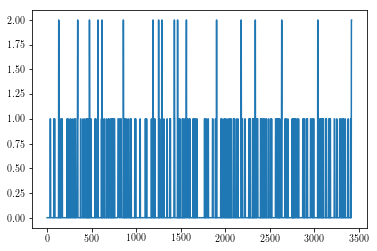

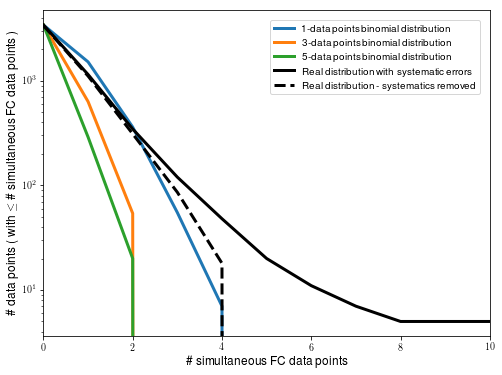

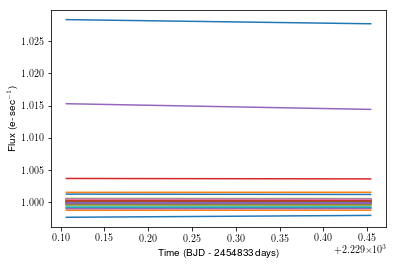

31 30
32 31
33 32
34 33
35 34
36 35
37 36
38 37
39 38
42 39


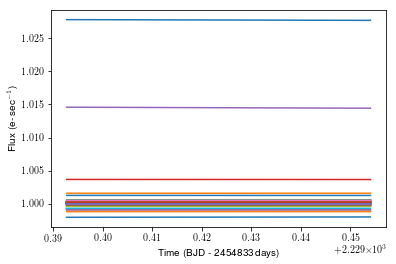

43 42
44 43
67 44


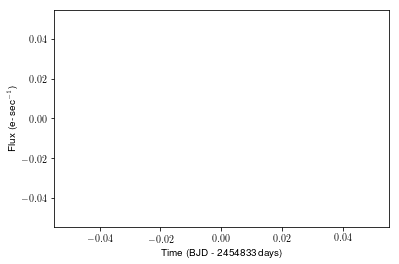

68 67
69 68
105 69


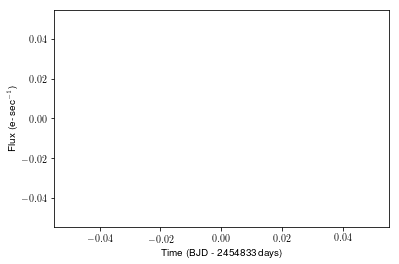

106 105
107 106
108 107
124 108


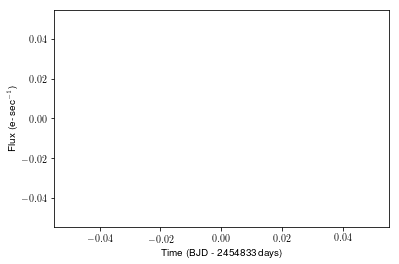

125 124
126 125
127 126
128 127
162 128


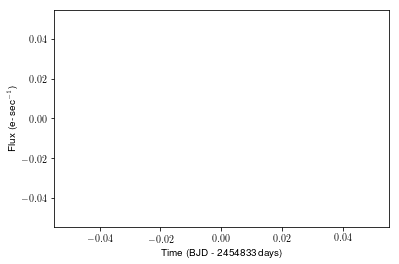

163 162
164 163
232 164


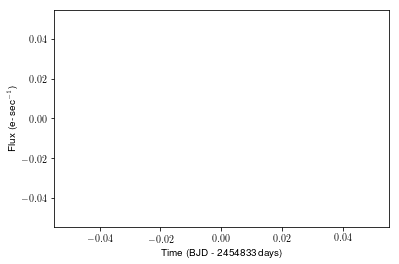

233 232
234 233
235 234
236 235
237 236


In [3]:
loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
sys, overlap = systematics_wrap(loc, oid_list, test, maxpoints=4, display=True)

In [4]:
sys_s = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/{0}_systematics.csv'.format(cluster,test),
                   header=None,usecols=[1])

# a=[510,511,512,509,332,331,330,329]
# sys_s[~sys_s.isin(a)].dropna(how='any')
sys_s

,1
0,30
1,31
2,32
3,33
4,34
5,35
6,36
7,37
8,38
9,39


In [5]:
sys_s.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/{0}_systematics.csv'.format(cluster,test))

## Match target pixel files with light curve time series

In [6]:
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}'.format(cluster))
flux, flares, tpfs = wrap_tpf_time_match(oid_list, test, C)

### Remove thruster firings

In [16]:
for oid in oid_list:
    remove_thruster_firings(tpfs, flux, flares, oid)
    remove_systematics2(flux, test, cluster, oid)
    
    flux[oid]['isflare_no_sys_no_thruster'] = (flux[oid].new_isflare == 1.) & (flux[oid].isflare_wo_systematics == 1.)
    
    start_stop = bool_to_edges(flux[oid].isflare_no_sys_no_thruster)
    flares[oid] = flares[oid].join(start_stop,rsuffix='_no_sys_no_thruster')
    
    flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
    flares[oid].to_csv('results/{}/{}_flares.csv'.format(test,oid))
    flux[oid].to_csv('results/{}/{}_flux.csv'.format(test,oid))

[91, 92, 93, 217, 218, 219, 233, 234, 235, 236, 237, 255, 256, 257, 1083, 1084, 1085, 1096, 1097, 1098, 3192, 3193, 3194]
0       91
1       92
2       93
3      217
4      218
5      219
6      233
7      234
8      235
9      236
10     237
11     255
12     256
13     257
14    1083
15    1084
16    1085
17    1096
18    1097
19    1098
20    3192
21    3193
22    3194
dtype: int64
/home/ekaterina/Documents/appaloosa/stars_shortlist/Pleiades
[280, 281, 282, 486, 487, 488, 489, 1658, 1659, 1660, 1764, 1765, 1766]
0      280
1      281
2      282
3      486
4      487
5      488
6      489
7     1658
8     1659
9     1660
10    1764
11    1765
12    1766
dtype: int64
/home/ekaterina/Documents/appaloosa/stars_shortlist/Pleiades
[33, 34, 35, 36, 37]
0    33
1    34
2    35
3    36
4    37
dtype: int64
/home/ekaterina/Documents/appaloosa/stars_shortlist/Pleiades
[33, 34, 35, 36, 37, 66, 67, 68, 315, 316, 317, 318, 1704, 1705, 1706]
0       33
1       34
2       35
3       36
4       37
5

In [ ]:
for oid in oid_list:
    myflares = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/{}_my_flares.txt'.format(cluster,test,oid),)
                          #header=None,names=['start','stop','istart','istop','comment'])
    myflares = myflares[myflares.comment!='comment']
    print(oid)
    print(myflares)
    myflares.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/{}_my_flares.txt'.format(cluster,test,oid))

### Decompose flags

In [ ]:
def flagdecomp(x,decomp=[]):
    '''
    Decompose cumulative flags
    '''
    flags = [0,1] 
    for i in range(1,20):
        flags.append(flags[i]*2)
        
    flag,i = find_nearest(flags, x)
    
    if x == 0:
        return decomp
    elif flag > x:
        decomp.append(flags[i-1])
        return flagdecomp(x-flags[i-1],decomp)
    elif flag <= x:
        decomp.append(flag)
        return flagdecomp(x-flag, decomp)
    return decomp

tot = np.asarray([flux[i].shape[0] for i in oid_list]).mean()
#print(np.asarray([flux[i].shape[0] for i in oid_list]).std())
thruster = np.asarray([(flux[i].tpf_flags[flux[i].tpf_flags > 524287./2.]).count() for i in oid_list]).mean()
#thruster/tot
# cal=[]
# for i in oid_list:
#     c = 0
#     for x in flux[i].tpf_flags:
#         if 8192 in flagdecomp(int(x),decomp=[]):
#             c+=1
#     cal.append(c)
print(tot)

### Appendix, scrambled pieces

In [ ]:
location = 'stars_shortlist/{}/results/{}'.format(cluster,test)
maxlen, seq = generate_sequence(oid_list, location)


In [ ]:
overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen,maxpoints=4)

In [ ]:
inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=True)

In [ ]:
display_comparison(inflated_binoms, overlap_dirty, overlap_clean, test)

In [ ]:
19/3432*100


In [ ]:
*100